In [1]:
from IPython import get_ipython

In [3]:
get_ipython().run_line_magic('reload_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')



In [4]:
from fastai.text import *
import ebooklib
from ebooklib import epub
from bs4 import BeautifulSoup

book = epub.read_epub('data/descartes1641.epub')

In [5]:
all_par = []

for doc in book.get_items_of_type(ebooklib.ITEM_DOCUMENT):
    if doc.is_chapter():
        chap_raw = doc.get_content()
        soup = BeautifulSoup(chap_raw)
        for par in soup.find_all('p', text=False, recursive=True):
            # filter out paragraphs with less then 50 characters
            if len(par.text) > 50:     
                try:
                    all_par = all_par + [par.text]
                except:
                    print(f'Not parsable: {par}')
    
df_texts = pd.DataFrame(all_par[1::], columns=['text'])
df_texts.shape[0]
df_texts.head()


,text
0,[Brackets] enclose editorial explanations. Sma...
1,"In his title for this work, Descartes is follo..."
2,Some years ago I was struck by how many false ...
3,I can do this without showing that all my beli...
4,Whatever I have accepted until now as most tru...


In [6]:
df_texts['text'][1]



'In his title for this work, Descartes is following a tradition (started by Aristotle) which uses ‘first philosophy’ as a label for metaphysics.'

In [7]:
# Language model
bs = 48
# stor_path = Path('/storage/deep-philosopher/')
stor_path = Path('/Users/jobvisser/repos/deep-philosopher/')
data_lm = (TextList.from_df(df_texts, stor_path, cols=['text'])
            .random_split_by_pct(.1)
            .label_for_lm()
            .databunch(bs=bs))

/Users/jobvisser/Library/Caches/pypoetry/virtualenvs/deep-philosopher-UfGILhcu-py3.7/lib/python3.7/site-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [12]:
data_lm.save()

TextLMDataBunch;

Train: LabelList (149 items)
x: LMTextList
xxbos [ xxmaj xxunk ] enclose xxunk xxunk . xxmaj small · xxunk · enclose xxunk that has been added , but can be xxunk as though it were part of the original xxunk . xxmaj xxunk xxunk , and also xxunk of xxunk that are not xxunk , are xxunk as xxunk to xxunk the structure of a xxunk or a thought . xxmaj every four - point xxunk . . . . xxunk the xxunk of a xxunk xxunk that seems to present more difficulty than it is xxunk .,xxbos xxmaj in his xxunk for this work , xxmaj descartes is following a xxunk ( started by xxmaj xxunk ) which uses ‘ first xxunk ’ as a xxunk for xxunk .,xxbos xxmaj some xxunk ago i was xxunk by how many false things i had believed , and by how doubtful was the structure of beliefs that i had based on them . i realized that if i wanted to xxunk anything in the xxunk that was xxunk and likely to last , i needed — just once in my life — to xxunk everything completely and start again from the xxunk . xxmaj 

In [8]:
data_lm.save(stor_path / 'data_lm')

In [48]:
help(data_lm.save)

Help on method save in module fastai.basic_data:

save(file: Union[pathlib.Path, str, _io.BufferedWriter, _io.BytesIO] = 'data_save.pkl') -> None method of fastai.text.data.TextLMDataBunch instance
    Save the `DataBunch` in `self.path/file`. `file` can be file-like (file or buffer)



In [9]:
data_lm.show_batch(rows=10)


idx,text
0,"i wanted to xxunk anything in the xxunk that was xxunk and likely to last , i needed — just once in my life — to xxunk everything completely and start again from the xxunk . xxmaj it looked like an xxunk task , and i xxunk to xxunk until i was old enough to be sure that there was nothing to be xxunk from xxunk it off any longer"
1,"xxunk in xxunk when they are xxunk , or that they are xxunk , or made of xxunk . xxmaj such people are xxunk , and i would be thought equally xxunk if i xxunk myself on them . xxbos xxmaj hopeful : xxmaj yet right now my eyes are certainly xxunk open when i look at this piece of xxunk ; i xxunk my head and it is n’t"
2,"two plus three makes five , and a square has only xxunk sides . xxmaj it seems impossible to suspect that such obvious truths might be false . xxbos xxmaj however , i have for many xxunk been sure that there is an all - powerful xxmaj god who made me to be the sort of xxunk that i am . xxmaj how do i know that he has n’t"
3,"things are merely dreams that the xxunk has xxunk as xxunk for my judgment . i shall consider myself as having no hands or eyes , or xxunk , or xxunk or senses , but as having xxunk believed that i had all these things . i shall xxunk xxunk in this xxunk of thought ; and even if i ca xxunk xxunk any truth , i shall at least"
4,"— does it follow that i do n’t exist either ? xxbos xxmaj hopeful : xxmaj no it does not follow ; for if i convinced myself of something then i certainly existed . xxbos xxmaj doubtful : xxmaj but there is a supremely powerful and cunning deceiver who deliberately xxunk me all the time ! xxbos xxmaj hopeful : xxmaj even then , if he is deceiving me i"
5,"i knew exactly what sort of thing it was . xxmaj if i had xxunk to put my xxunk of the body into words , i would have said this : xxbos xxmaj by a ‘ body ’ i understand whatever has a xxunk shape and position , and can xxunk a · region of · xxunk in such a way as to keep every other body out of it"
6,". xxmaj what kind of a thing ? i have xxunk that : a thinking thing . xxbos xxmaj what else am i ? i will use my imagination to see if i am anything more . i am not that structure of limbs and organs that is called a human body ; nor am i a xxunk xxunk that xxunk the limbs — a xxunk , fire , xxunk"
7,"why should it not be ? xxmaj is n’t it one and the same ‘ i ’ who now xxbos affirms this one xxunk , that i exist and think · , xxbos is aware of others that seem to come from the senses ? xxbos xxmaj is n’t all this just as true as the fact that i exist , even if i am in a xxunk xxunk ,"
8,"they understand best of all , namely the bodies that we touch and see . i do n’t mean bodies in general — for our general thoughts are xxunk to be confused — but one particular body : this piece of wax , for example . xxmaj it has just been taken from the xxunk ; it still tastes of honey and has the xxunk of the xxunk from which"
9,"and changeable . xxmaj also , what does ‘ extended ’ mean ? xxmaj is the wax ’s extension also unknown ? xxmaj it increases if the wax xxunk , and increases again if it xxunk ; the wax can be extended in many more ways ( · that is , with many more shapes · ) than i will ever bring before my imagination . i am xxunk to"


In [10]:
# view the most common dictionary terms
data_lm.vocab.itos[:15]


['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 ',',
 'i',
 'the',
 'that',
 '.',
 'of']

In [11]:
# Train Language Model
# drop_mult is a parameter that controls the % of drop-out used
learn = language_model_learner(data_lm, AWD_LSTM, 
            drop_mult=0.7)


In [12]:
# use learning rate finder to identify a good learning rate to use
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


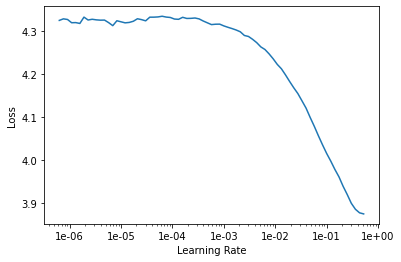

In [13]:
learn.recorder.plot(skip_end=15)

In [14]:
# as a rule of thumb, review the plot above and choose the learning rate 
# with the steepest slope to fit the model
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,4.251326,4.084511,0.224702,00:12
1,4.148220,3.809978,0.249702,00:12
2,3.989538,3.646709,0.265774,00:11
3,3.829430,3.519116,0.275000,00:11
4,3.680995,3.490135,0.272024,00:11
5,3.548779,3.454338,0.280655,00:11
6,3.431424,3.430956,0.280060,00:13
7,3.340652,3.425889,0.283929,00:10
8,3.271631,3.430627,0.280060,00:10
9,3.212852,3.421905,0.279167,00:10


In [42]:
! pwd

/Users/jobvisser/repos/deep-philosopher


In [14]:
learn.save('deep_philosopher_head')


NameError: name 'learn' is not defined

In [16]:
learn.load('deep_philosopher_head');


In [17]:
# To complete the fine-tuning, we can then unfeeze and launch 
# a new training to fine-tune all layers of the model.
learn.unfreeze()

In [18]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.941353,3.444343,0.277381,00:26
1,2.874441,3.437474,0.280060,00:24
2,2.759536,3.458321,0.276786,00:25
3,2.643751,3.491671,0.276786,00:28
4,2.552804,3.503220,0.275298,00:27


In [19]:
learn.save('deep_philosopher_fine_tuned')
learn.save_encoder('fine_tuned_enc')

In [20]:
learn.load('deep_philosopher_fine_tuned')


LanguageLearner(data=TextLMDataBunch;

Train: LabelList (149 items)
x: LMTextList
xxbos xxmaj in his xxunk for this work , xxmaj descartes is following a xxunk ( xxunk by xxmaj xxunk ) which uses ‘ first xxunk ’ as a xxunk for xxunk .,xxbos xxmaj some xxunk ago i was xxunk by how many false things i had believed , and by how doubtful was the structure of beliefs that i had based on them . i xxunk that if i wanted to xxunk anything in the xxunk that was xxunk and likely to last , i needed — just once in my life — to xxunk everything completely and start again from the xxunk . xxmaj it looked like an xxunk task , and i xxunk to xxunk until i was old enough to be sure that there was nothing to be xxunk from xxunk it off any longer . i have now xxunk it for so long that i have no xxunk for going on xxunk to do it rather than xxunk to work . xxmaj so today i have set all my xxunk xxunk and xxunk for myself a clear xxunk of free time . i am here quite alone , and at last i will xxunk myself 

In [28]:
# adjust below parameters to test inference (generated texts)

TEXT = "Life will"
N_WORDS = 40
N_SENTENCES = 2


In [29]:
print("\n".join(learn.predict(TEXT, N_WORDS) for _ in range(N_SENTENCES)))


Life will be said to be true ; but a certain and obscure perception of it : a judgment may merely be caused when it is set apart from itself 
Life will n’t have life in my intellect ; it has no memory at all 


In [31]:
pred = learn.predict(TEXT, N_WORDS)

In [40]:
pred.split("!|,")

['Life will now go wrong but it should come from things that are dreaming ! xxbos Decision to affirm or deny had come from a faculty of mine , was been made by former Latin Causes of God']